Test Problem
=======================

Now that we have gotten a firm understandting of the PML we can start implementing a forward pass: this is to generate training data for our model. We first, however, implement a test case using the same tools as we hope to in the main problem, NGSolve within Python. The test problem will be to model a plan wave in a simple domain.

In [1]:
%matplotlib notebook
import netgen.gui
from netgen.geom2d import SplineGeometry
from ngsolve import *
import matplotlib.pyplot as plt
import numpy as np

geo = SplineGeometry()
geo.AddCircle( (0,0), 2, leftdomain=2, rightdomain=0, bc="domain_bc")
geo.AddCircle( (0,0), 1, leftdomain=1, rightdomain=2, bc="scatterer_bc")
geo.SetMaterial(1, "scatterer")
geo.SetMaterial(2, "domain")
mesh = Mesh(geo.GenerateMesh (maxh=0.05))
mesh.Curve(3)

mesh.SetPML(pml.Radial(rad=1.95,alpha=1j,origin=(0,0)), "domain") 

k_0 = 15 #72
k_tilde = 14.621 #27

domain_values = {'scatterer': k_tilde, 'domain': k_0}
values_list = [domain_values[mat] for mat in mesh.GetMaterials()]
k = CoefficientFunction(values_list)

fes = H1(mesh, complex=True, order=5, dirichlet="domain_bc")

n = specialcf.normal(2)

def forward_pass(theta):

    u_in = exp(1j*k_0*(cos(theta)*x + sin(theta)*y)) #Incoming Plane Wave. 

    #Defining our test and solution functions.
    u = fes.TrialFunction()
    v = fes.TestFunction()

    #Defining our LHS of the weak formulation.
    a = BilinearForm(fes)
    a += grad(u) * grad(v) * dx
    a += - k**2 * u * v * dx
    
    #Defining the RHS of our weak formulation.
    f = LinearForm(fes)
    f += -u_in * (k**2 - k_0**2) * v * dx
    
    a.Assemble()
    f.Assemble()

    #Solving our problem.
    u_s = GridFunction(fes, name="u")
    u_s.vec.data = a.mat.Inverse() * f.vec

    u_tot = u_in + u_s
    
    return [u_in, u_s, u_tot]

s = (17/37)*np.pi

calc = forward_pass(s)
u_in = calc[0]
u_s = calc[1]
u_tot = calc[2]

#This allows us to see the solutions on the NGSolve gui.
Draw(u_in, mesh, "u_in")
Draw(u_s, mesh, "u_s")
Draw(u_tot, mesh, "u_tot")

In [2]:
fes = H1(mesh, complex=True, order=5, dirichlet="domain_bc")

n = specialcf.normal(2)

#ecomp = exp(-1j*k_0*(cos(r)*x + sin(r)*y))
#ecomp_n = CoefficientFunction((ecomp.Diff(x),ecomp.Diff(y)))*n

def forward_pass(theta):

    u_in = exp(1j*k_0*(cos(theta)*x + sin(theta)*y)) #Incoming Plane Wave with direction paramaterised by theta. 

    #Defining our test and solution functions.
    u = fes.TrialFunction()
    v = fes.TestFunction()

    #Defining our LHS of the weak formulation.
    a = BilinearForm(fes)
    a += grad(u) * grad(v) * dx
    a += - k**2 * u * v * dx
    #a += - 1j*k * u * v * ds("domain_bc")
    
    #a += -Grad(u).Trace()*n*v*ds("domain_bc")
    
    #Defining the RHS of our weak formulation.
    f = LinearForm(fes)
    # += -ecomp_n*v*ds("domain_bc")
    f += -u_in * (k**2 - k_0**2) * v * dx
    
    a.Assemble()
    f.Assemble()

    #Solving our problem.
    u_s = GridFunction(fes, name="u")
    u_s.vec.data = a.mat.Inverse() * f.vec

    u_tot = u_in + u_s
    
    return [u_in, u_s, u_tot]

s = (17/37)*np.pi

calc = forward_pass(s)
u_in = calc[0]
u_s = calc[1]
u_tot = calc[2]

In [3]:
Draw(u_in, mesh, "u_in")
Draw(u_s, mesh, "u_s")
Draw(u_tot, mesh, "u_tot")

<IPython.core.display.Javascript object>


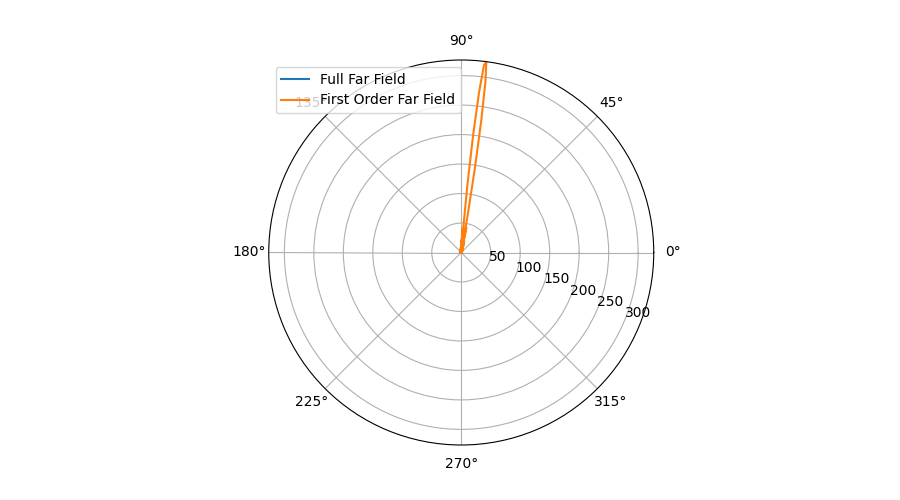

<IPython.core.display.Javascript object>


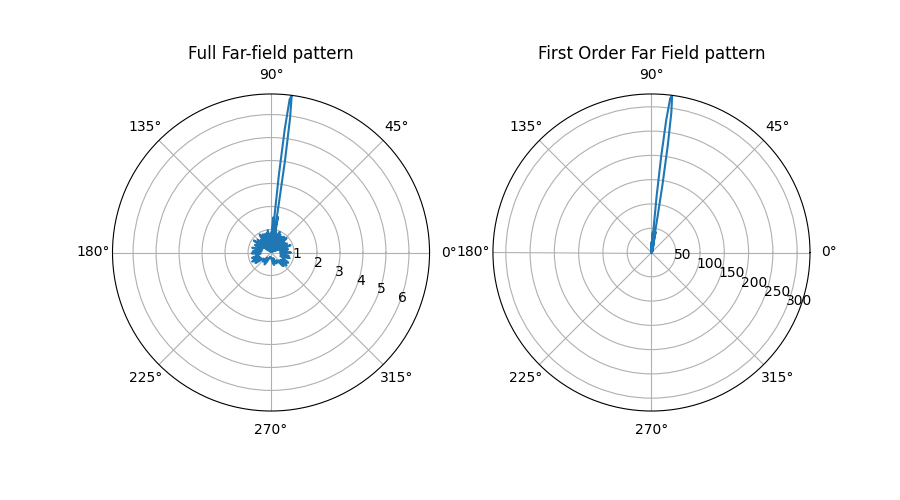

In [4]:
def f1_field(r,s):
    
    temp = Integrate(exp(-1j*k_0*((cos(r)-cos(s))*x+(sin(r)-sin(s))*y))*(k**2 - k_0**2),
              mesh,definedon=mesh.Materials("scatterer"))
    
    return (exp(1j*r)/np.sqrt(8*np.pi*k_0))*temp

def ff_field(r):
    
    n = specialcf.normal(2)
    us_n = BoundaryFromVolumeCF(Grad(u_s)*n)
    ecomp = exp(-1j*k_0*(cos(r)*x + sin(r)*y))
    ecomp_n = CoefficientFunction((ecomp.Diff(x),ecomp.Diff(y)))*n
    
    temp = Integrate(u_s*ecomp_n - us_n*ecomp, mesh,definedon=mesh.Boundaries("scatterer_bc"))
    
    return (exp(1j*r)/np.sqrt(8*np.pi*k_0))*temp

theta = np.arange(0, 2*np.pi, 0.01)

mag1 = []

mag2 = []

for r in theta:
    
    mag1.append(abs(ff_field(r)))
    
    mag2.append(abs(f1_field(r,s)))
    
fig = plt.figure(figsize=(9, 5))

ax = plt.subplot(1, 1, 1, projection='polar')

ax.plot(theta, mag1)
ax.plot(theta, mag2)
ax.set_rmax(max(mag2))
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)
plt.legend(["Full Far Field", "First Order Far Field"])

plt.show()

fig2 = plt.figure(figsize=(9, 5))

ax = plt.subplot(1, 2, 1, projection='polar')

ax.plot(theta, mag1)
ax.set_rmax(max(mag1))
ax.set_rlabel_position(-22.5)
ax.grid(True)
plt.title('Full Far-field pattern')

ax = plt.subplot(1, 2, 2, projection='polar')

ax.plot(theta, mag2)
ax.set_rmax(max(mag2))
ax.set_rlabel_position(-22.5)
ax.grid(True)
plt.title('First Order Far Field pattern')

plt.show()